In [1]:
!pip install transformers --upgrade
!pip install resampy


# Question 1:  Speech Emotion Recognition on shEMO dataset using HuBERT

**HuBERT** leverages the masked prediction loss over sequences, e.g.,
Google’s Bidirectional Encoder Representations from Transformers, or BERT, method, to represent the sequential structure of speech. HuBERT uses an offline clustering step to generate noisy labels for Masked Language Model pretraining. Concretely, HuBERT consumes masked continuous speech features to predict predetermined cluster assignments. The predictive loss is applied over only the masked regions, forcing the model to learn good high-level representations of unmasked inputs in order to infer the targets of masked ones correctly.

The official [paper](https://arxiv.org/pdf/2106.07447.pdf).




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import librosa
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import shutil
from google.colab import drive
from google.colab import files


## 1-3. Pre-processing

In [3]:
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mansourehk/shemo-persian-speech-emotion-detection-database
!unzip -q shemo-persian-speech-emotion-detection-database.zip

Saving kaggle.json to kaggle.json
shemo-persian-speech-emotion-detection-database.zip: Skipping, found more recently modified local copy (use --force to force download)
replace female/F01A01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
male_folder = "./male/"
female_folder = "./female/"

In [5]:
def extract_features(folder):
    features = []
    for filename in os.listdir(folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder, filename)
            # Load the audio file
            audio, sr = librosa.load(file_path, sr=None)
            print(f"Processing {filename}: Sampling Rate - {sr}, Shape - {audio.shape}")
            emotion = filename[3]
            # Compute statistical features
            duration = len(audio) / sr
            print(f"Duration: {duration} seconds")
            mean = audio.mean()
            std = audio.std()
            features.append([filename, emotion, duration, mean, std])
    return features

In [6]:
male_features = extract_features(male_folder)
female_features = extract_features(female_folder)

Streaming output truncated to the last 5000 lines.
Processing M43H01.wav: Sampling Rate - 44100, Shape - (119301,)
Duration: 2.705238095238095 seconds
Processing M12A16.wav: Sampling Rate - 44100, Shape - (135099,)
Duration: 3.0634693877551022 seconds
Processing M08N04.wav: Sampling Rate - 44100, Shape - (120812,)
Duration: 2.739501133786848 seconds
Processing M40N20.wav: Sampling Rate - 44100, Shape - (113915,)
Duration: 2.583106575963719 seconds
Processing M48N07.wav: Sampling Rate - 22050, Shape - (84282,)
Duration: 3.822312925170068 seconds
Processing M21W02.wav: Sampling Rate - 44100, Shape - (25963,)
Duration: 0.5887301587301588 seconds
Processing M25A64.wav: Sampling Rate - 44100, Shape - (70038,)
Duration: 1.5881632653061224 seconds
Processing M04N14.wav: Sampling Rate - 44100, Shape - (818564,)
Duration: 18.56154195011338 seconds
Processing M25S03.wav: Sampling Rate - 44100, Shape - (196592,)
Duration: 4.457868480725623 seconds
Processing M28A33.wav: Sampling Rate - 44100, Sha

In [7]:
all_features = male_features + female_features
all_df = pd.DataFrame(all_features, columns=["Filename", "Emotion", "Duration", "Mean", "Std"])


In [8]:
print("all_df Statistics:")
print(all_df.describe())

all_df Statistics:
          Duration          Mean          Std
count  3000.000000  3.000000e+03  3000.000000
mean      4.111796 -4.917908e-05     0.068586
std       3.414900  7.159096e-04     0.003826
min       0.358617 -1.997973e-02     0.058740
25%       1.955108 -6.370426e-06     0.066007
50%       3.079626 -4.609616e-07     0.067644
75%       5.104076  4.195887e-06     0.070112
max      33.328005  9.773192e-04     0.108408


* A: anger emotion
* F: female speaker (if used at the beginning of the label e.g.F14A09) or fear (if used in the middle of the label e.g. M02F01)
* H : happiness
* M : male speaker
* N : neutral
* S : sadness
* W : surprise

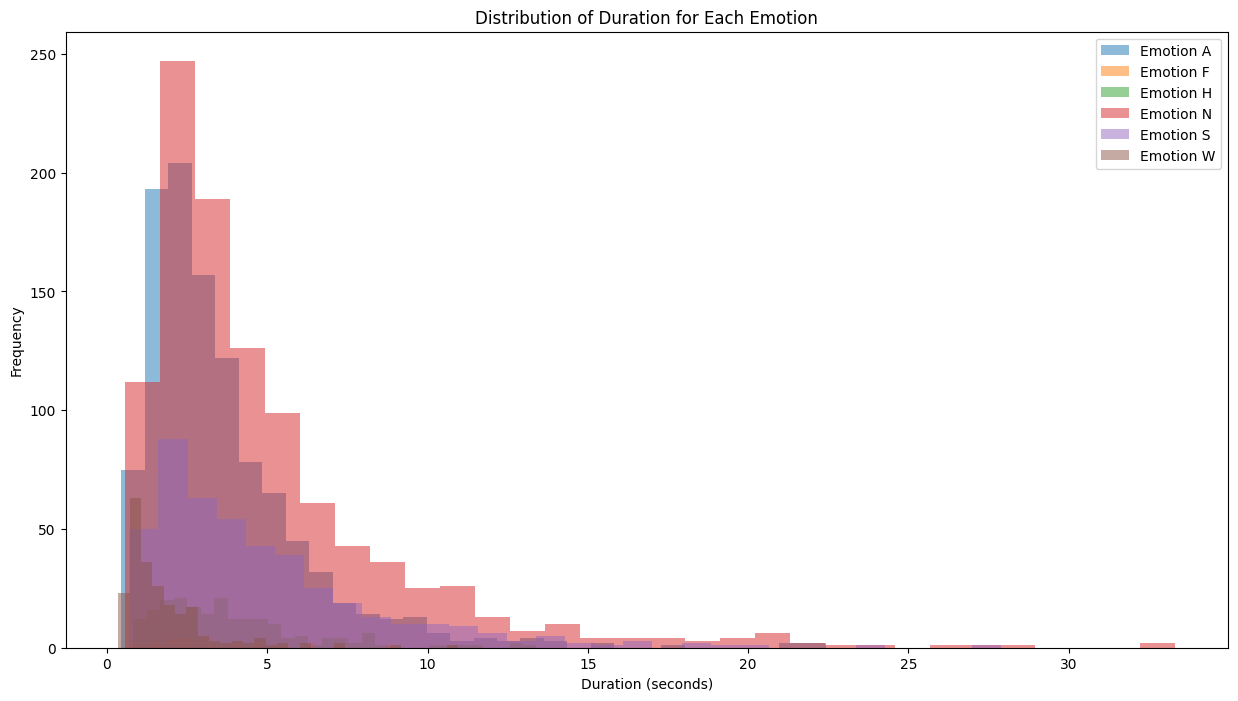

In [9]:
emotions = ["A", "F", "H", "N", "S", "W"]
plt.figure(figsize=(15, 8))
for emotion in emotions:
    emotion_data = all_df[all_df["Emotion"] == emotion]
    plt.hist(emotion_data["Duration"], bins=30, alpha=0.5, label=f"Emotion {emotion}")

plt.title("Distribution of Duration for Each Emotion")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

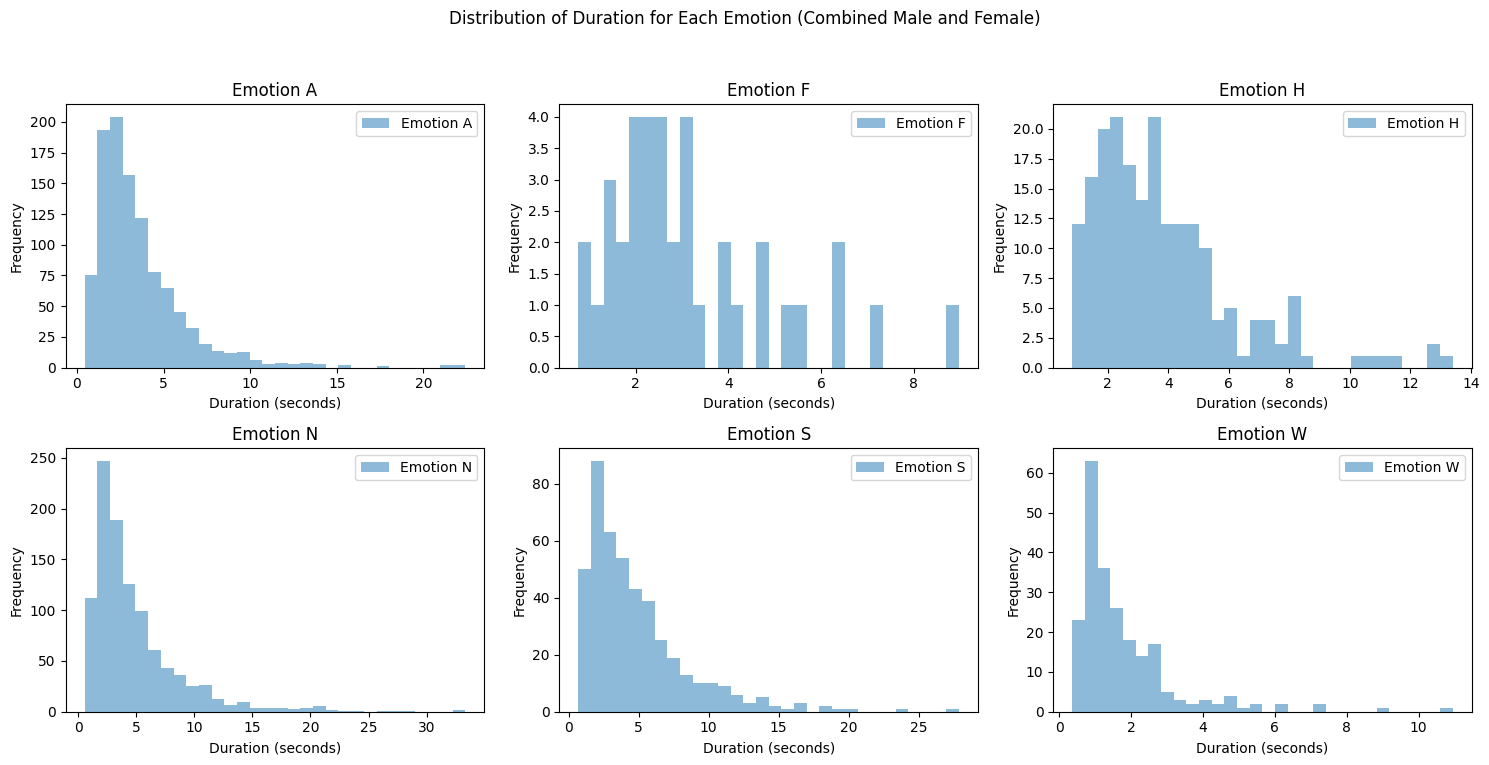

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.suptitle("Distribution of Duration for Each Emotion (Combined Male and Female)")

for ax, emotion in zip(axes.flatten(), emotions):
    emotion_data = all_df[all_df["Emotion"] == emotion]
    ax.hist(emotion_data["Duration"], bins=30, alpha=0.5, label=f"Emotion {emotion}")
    ax.set_title(f"Emotion {emotion}")
    ax.set_xlabel("Duration (seconds)")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

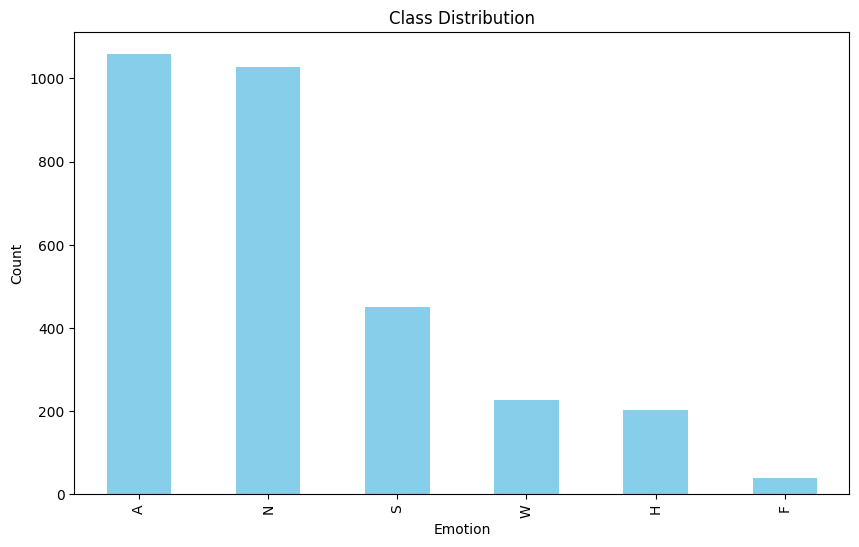

Class Distribution:
A    1059
N    1028
S     449
W     225
H     201
F      38
Name: Emotion, dtype: int64


In [11]:
class_distribution = all_df["Emotion"].value_counts()

plt.figure(figsize=(10, 6))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()
print("Class Distribution:")
print(class_distribution)

We can see the data is imbalance in specific emotion classes.

We have possible solutions to solve the problem

We can do data augmentation, under-sampling, Oversampling and so on.

In [12]:
all_df

,Filename,Emotion,Duration,Mean,Std
0,M28A38.wav,A,1.741701,-7.227210e-07,0.071448
1,M12N73.wav,N,2.114422,4.373447e-06,0.068950
2,M12N41.wav,N,1.303832,3.996545e-07,0.072163
3,M04N05.wav,N,8.109433,-1.416669e-05,0.064677
4,M28A42.wav,A,4.118662,-9.916411e-07,0.066775
...,...,...,...,...,...
2995,F20H04.wav,H,3.896485,-1.950205e-06,0.067256
2996,F28A04.wav,A,3.699161,2.619005e-09,0.066601
2997,F24N16.wav,N,3.884195,-6.385258e-06,0.066316
2998,F21A15.wav,A,1.714966,-8.037950e-07,0.074872


In [13]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

idx = np.random.randint(0, len(all_df))
sample = all_df.iloc[idx]
Filename = sample["Filename"]
label = sample["Emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

if(Filename[0] == 'M'):
  path = './male/'+sample['Filename']
else:
  path = './female/'+sample['Filename']

print(path)
speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()


ID Location: 1117
      Label: N

./male/M40N16.wav


In [14]:
save_path = "./"

train_df , test_temp_df = train_test_split(all_df, test_size=0.2, random_state=101, stratify=all_df["Emotion"])

val_df , test_df = train_test_split(test_temp_df, test_size=0.5, random_state=101, stratify=test_temp_df["Emotion"])

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)
val_df.to_csv(f"{save_path}/validation.csv", sep="\t", encoding="utf-8", index=False)

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2400, 5)
(300, 5)
(300, 5)


In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

X = all_df[["Duration", "Mean", "Std"]]
y = all_df["Emotion"]

In [16]:
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

total_samples = len(all_df)
train_samples = len(X_train_temp)
val_samples = len(X_val)
test_samples = len(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_temp, y_train_temp)



resampled_train_samples = len(X_train_resampled)


print("Total Samples:", total_samples)
print("\nTraining Set Samples:", resampled_train_samples)
print("Validation Set Samples:", val_samples)
print("Testing Set Samples:", test_samples)

print("Training Set Class Distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

print("\nValidation Set Class Distribution:")
print(pd.Series(y_val).value_counts(normalize=True))

print("\nTesting Set Class Distribution:")
print(pd.Series(y_test).value_counts(normalize=True))


Total Samples: 3000

Training Set Samples: 5082
Validation Set Samples: 300
Testing Set Samples: 300
Training Set Class Distribution:
W    0.166667
H    0.166667
A    0.166667
N    0.166667
S    0.166667
F    0.166667
Name: Emotion, dtype: float64

Validation Set Class Distribution:
A    0.353333
N    0.343333
S    0.150000
W    0.076667
H    0.066667
F    0.010000
Name: Emotion, dtype: float64

Testing Set Class Distribution:
A    0.353333
N    0.343333
S    0.150000
W    0.073333
H    0.066667
F    0.013333
Name: Emotion, dtype: float64


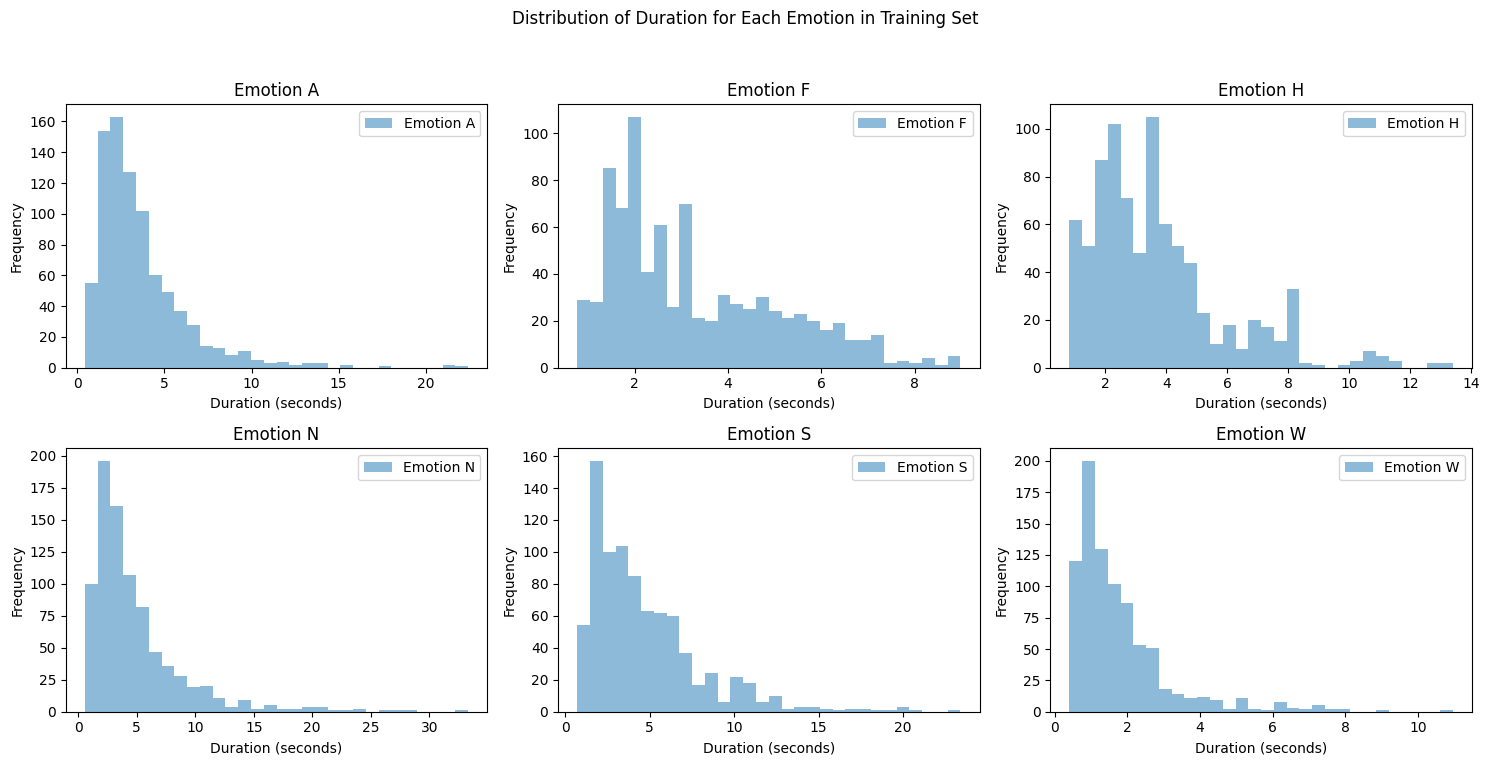

In [17]:
emotions = ["A", "F", "H", "N", "S", "W"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.suptitle("Distribution of Duration for Each Emotion in Training Set")

for ax, emotion in zip(axes.flatten(), emotions):
    emotion_data = X_train_resampled[y_train_resampled == emotion]
    ax.hist(emotion_data["Duration"], bins=30, alpha=0.5, label=f"Emotion {emotion}")
    ax.set_title(f"Emotion {emotion}")
    ax.set_xlabel("Duration (seconds)")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

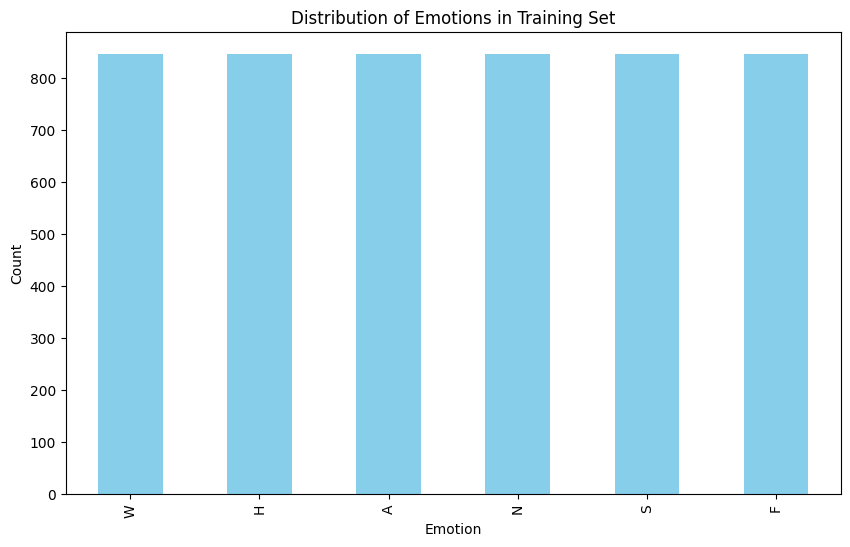

In [18]:
plt.figure(figsize=(10, 6))
pd.Series(y_train_resampled).value_counts().plot(kind="bar", color="skyblue")
plt.title("Distribution of Emotions in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [19]:
train_df.head()


,Filename,Emotion,Duration,Mean,Std
0,M49N02.wav,N,5.012290,0.000009,0.065646
1,M03A02.wav,A,0.969546,0.000013,0.075046
2,M30A01.wav,A,1.311542,0.000002,0.071996
3,M44H03.wav,H,8.001519,-0.000004,0.065909
4,F10A02.wav,A,4.075737,-0.000004,0.066186


In [20]:
val_df.head()


,Filename,Emotion,Duration,Mean,Std
0,M28S18.wav,S,5.843900,2.614141e-06,0.065292
1,M50A03.wav,A,5.670295,-3.320736e-07,0.066098
2,F17S10.wav,S,0.892540,-2.089719e-04,0.084736
3,M20N02.wav,N,5.394218,-4.931870e-06,0.067034
4,F24S13.wav,S,5.241293,-5.983210e-06,0.065561


In [21]:
test_df.head()

,Filename,Emotion,Duration,Mean,Std
0,M08N06.wav,N,1.304785,0.000001,0.072191
1,M16A32.wav,A,1.776485,-0.000040,0.069909
2,F07W01.wav,W,1.304853,0.000040,0.072111
3,F12N12.wav,N,2.831406,0.000004,0.067520
4,M03A07.wav,A,1.416961,-0.000088,0.071522


In [22]:
input_column = "Filename"
output_column = "Emotion"

In [23]:
label_list = train_df["Emotion"].unique()
label_list.sort()
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 6 classes: ['A' 'F' 'H' 'N' 'S' 'W']


### 1-3-2 Dataloader

`pad_collate` is a custom collate function that uses `pad_sequence` to pad sequences in a batch to have the same length as the `longest sequence` in that `batch`

Now, let's compare this method with the method that doubles the length of all sequences in the dataset by a certain value with padding:

---

Advantages and disadvantages of the method that pads each `batch separately`:

Advantages:

* Minimizes wasted computation: Only pads sequences in a batch to the length of the longest sequence in that specific batch, minimizing unnecessary computation.
* More memory-efficient: Reduces memory consumption compared to padding all sequences to the length of the longest sequence in the entire dataset.

Disadvantages:

* Variable batch size: Different batches may have different sizes, leading to variable computation times for different batches.

---

Advantages and disadvantages of the method that pads all sequences to the length of the longest sequence in the dataset:

Advantages:

* Fixed batch size: All batches have the same size, simplifying the training process.
* Consistent computation time: All batches take the same amount of time to process, making it easier to estimate training times.

Disadvantages:

* Increased memory usage: Padding all sequences to the length of the longest sequence in the dataset may lead to increased memory consumption, especially for datasets with long sequences.
* Potentially wasteful computation: Some computation may be wasted on padding when sequences in a batch are shorter than the maximum length.

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [25]:
class ShEMODataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return torch.tensor(self.features[index]), torch.tensor(self.labels[index])

In [26]:
train_dataset = ShEMODataset(X_train_resampled, y_train_resampled)
validation_dataset = ShEMODataset(X_val, y_val)
test_dataset = ShEMODataset(X_test, y_test)

In [27]:
def pad_collate(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_sequences, torch.tensor(labels)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

## Problem description
### 1-4-1. Generating valid representation of the world

Indeed, unlike models based on text transformers like BERT, HuBERT, being designed for speech signals, doesn't generate a single embedding vector for the entire input sequence. Instead, it typically provides embeddings for smaller contextual chunks or frames of the input audio. To create a fixed-size representation for the entire input sequence, we can aggregate these embeddings using pooling or similar techniques.

One common approach is to use mean pooling or max pooling across the temporal dimension to obtain a fixed-size representation

* `Mean Pooling`: Taking the mean across the temporal dimension helps capture the average information from the entire sequence. This can be useful when the emotion information is distributed across the entire utterance.

* `Max Pooling`: Taking the maximum value across the temporal dimension emphasizes the most salient features in the sequence. This can be helpful when the emotion is conveyed through specific key moments in the speech.


In [29]:
train_df['Audio_Path'] = train_df.apply(lambda row: f"./male/{row['Filename']}" if row['Filename'][0] == 'M' else f"./female/{row['Filename']}", axis=1)
val_df['Audio_Path'] = val_df.apply(lambda row: f"./male/{row['Filename']}" if row['Filename'][0] == 'M' else f"./female/{row['Filename']}", axis=1)
test_df['Audio_Path'] = test_df.apply(lambda row: f"./male/{row['Filename']}" if row['Filename'][0] == 'M' else f"./female/{row['Filename']}", axis=1)

In [30]:
train_df.head()

,Filename,Emotion,Duration,Mean,Std,Audio_Path
0,M49N02.wav,N,5.012290,0.000009,0.065646,./male/M49N02.wav
1,M03A02.wav,A,0.969546,0.000013,0.075046,./male/M03A02.wav
2,M30A01.wav,A,1.311542,0.000002,0.071996,./male/M30A01.wav
3,M44H03.wav,H,8.001519,-0.000004,0.065909,./male/M44H03.wav
4,F10A02.wav,A,4.075737,-0.000004,0.066186,./female/F10A02.wav


In [31]:
import librosa
import librosa.display
import IPython.display as ipd

In [32]:
ipd.Audio("./male/M18N15.wav")

In [33]:
#def feature_extraction(file_path):
#    # Loading audio file
#    audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
#
#    # Extracting features
#    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50).T, axis=0)
#    return mfcc

In [ ]:
#features = {}
#features["./male/M18N15.wav"] = feature_extraction("./male/M18N15.wav")
#features["./male/M18N15.wav"],len(features["./male/M18N15.wav"])

In [35]:
#features_list = []
#
#samples_to_process = train_df
#for index, row in samples_to_process.iterrows():
#    file_path = row['Audio_Path']
#    features  = feature_extraction(file_path)
#    features_list.append({'file_path': file_path, 'features': features, 'label': row['Emotion']})

In [36]:
#print(len(features_list))
#features_list[22]

In [42]:
import torchaudio
from torchaudio.transforms import Resample
from transformers import Wav2Vec2FeatureExtractor
import pandas as pd

# Function to extract features using Wav2Vec2FeatureExtractor
def feature_extraction(file_path, target_sampling_rate=16000):
    waveform, original_sample_rate = torchaudio.load(file_path)

    # Resample to the target sampling rate
    resampler = Resample(original_sample_rate, target_sampling_rate)
    waveform = resampler(waveform)

    # Extract features using Wav2Vec2FeatureExtractor
    features = feature_extractor(waveform.squeeze().numpy(), sampling_rate=target_sampling_rate, return_tensors="pt")

    return features['input_values'].squeeze()

# Initialize Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

#train
features_list_train = []
samples_to_process = train_df

for index, row in samples_to_process.iterrows():
    file_path = row['Audio_Path']
    features = feature_extraction(file_path)
    features_list_train.append({'file_path': file_path, 'features': features, 'label': row['Emotion']})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [43]:
# validation and test feature extraction
features_list_validation = []
samples_to_process = val_df

for index, row in samples_to_process.iterrows():
    file_path = row['Audio_Path']
    features = feature_extraction(file_path)
    features_list_validation.append({'file_path': file_path, 'features': features, 'label': row['Emotion']})


samples_to_process = test_df
features_list_test = []

for index, row in samples_to_process.iterrows():
    file_path = row['Audio_Path']
    features = feature_extraction(file_path)
    features_list_test.append({'file_path': file_path, 'features': features, 'label': row['Emotion']})

In [46]:
features_list_train

[{'file_path': './male/M49N02.wav',
  'features': tensor([ 3.5777e-04, -4.0375e-04, -1.2688e-04,  ...,  6.0508e-05,
          -3.5205e-04, -6.4822e-05]),
  'label': 'N'},
 {'file_path': './male/M03A02.wav',
  'features': tensor([-0.0004, -0.0001, -0.0003,  ..., -0.0002, -0.0001, -0.0002]),
  'label': 'A'},
 {'file_path': './male/M30A01.wav',
  'features': tensor([-0.0002, -0.0004, -0.0003,  ..., -0.0002, -0.0002, -0.0005]),
  'label': 'A'},
 {'file_path': './male/M44H03.wav',
  'features': tensor([ 0.0064,  0.0036,  0.0062,  ..., -0.0037, -0.0014, -0.0001]),
  'label': 'H'},
 {'file_path': './female/F10A02.wav',
  'features': tensor([-0.0001,  0.0002,  0.0002,  ..., -0.0108, -0.0011,  0.0049]),
  'label': 'A'},
 {'file_path': './male/M25W10.wav',
  'features': tensor([-1.6670e-04, -1.2195e-04, -1.5458e-04,  ..., -1.7456e-04,
          -8.6843e-05, -2.0244e-04]),
  'label': 'W'},
 {'file_path': './male/M28A10.wav',
  'features': tensor([-1.1228e-02, -1.3138e-02, -1.5776e-02,  ..., -4.55

In [47]:
features_list_validation

[{'file_path': './male/M28S18.wav',
  'features': tensor([ 9.6701e-05, -8.8310e-05,  1.0739e-05,  ...,  3.6876e-05,
          -9.0968e-05,  3.3458e-05]),
  'label': 'S'},
 {'file_path': './male/M50A03.wav',
  'features': tensor([-0.0011, -0.0009, -0.0015,  ...,  0.0007,  0.0007,  0.0009]),
  'label': 'A'},
 {'file_path': './female/F17S10.wav',
  'features': tensor([0.0011, 0.0032, 0.0021,  ..., 0.0084, 0.0087, 0.0087]),
  'label': 'S'},
 {'file_path': './male/M20N02.wav',
  'features': tensor([ 2.8648e-04,  1.6804e-04, -1.1483e-04,  ...,  1.7709e-04,
          -6.3850e-05, -5.1267e-04]),
  'label': 'N'},
 {'file_path': './female/F24S13.wav',
  'features': tensor([-0.0007, -0.0004, -0.0002,  ...,  0.0008,  0.0008,  0.0010]),
  'label': 'S'},
 {'file_path': './male/M27N33.wav',
  'features': tensor([ 0.0028,  0.0030,  0.0035,  ...,  0.0003, -0.0001,  0.0004]),
  'label': 'N'},
 {'file_path': './female/F20N01.wav',
  'features': tensor([-6.1143e-04, -3.1897e-04, -7.2102e-04,  ...,  3.7461

In [50]:
features_list_train[0]

{'file_path': './male/M49N02.wav',
 'features': tensor([ 3.5777e-04, -4.0375e-04, -1.2688e-04,  ...,  6.0508e-05,
         -3.5205e-04, -6.4822e-05]),
 'label': 'N'}

In [49]:
features_list_test[5]

{'file_path': './male/M48N08.wav',
 'features': tensor([ 0.0016, -0.0035, -0.0117,  ...,  0.0004, -0.0005,  0.0007]),
 'label': 'N'}

### 1-4-2. Train model

In [76]:
import torch
from transformers import HubertForSequenceClassification
from transformers import HubertModel, HubertConfig
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn

In [52]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    features, labels = zip(*batch)

    # Pad sequences in the batch to the maximum length
    padded_features = pad_sequence(features, batch_first=True, padding_value=0)

    return padded_features, torch.tensor(labels)


In [66]:
# Load Hubert model and tokenizer
model_name = "facebook/hubert-base-ls960"
hubert_model = HubertModel.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_v', 'encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel

In [67]:
label_mapping = {"A": 0, "F": 1, "H": 2, "N": 3, "S": 4, "W": 5}

for data_list in [features_list_train, features_list_validation]:
    for item in data_list:
        item['label'] = label_mapping[item['label']]

In [68]:
train_data = [(torch.Tensor(item['features']), torch.tensor(item['label'])) for item in features_list_train]
validation_data = [(torch.Tensor(item['features']), torch.tensor(item['label'])) for item in features_list_validation]
test_data = [(torch.Tensor(item['features']), item['file_path']) for item in features_list_test]


In [71]:
train_data

[(tensor([ 3.5777e-04, -4.0375e-04, -1.2688e-04,  ...,  6.0508e-05,
          -3.5205e-04, -6.4822e-05]),
  tensor(3)),
 (tensor([-0.0004, -0.0001, -0.0003,  ..., -0.0002, -0.0001, -0.0002]),
  tensor(0)),
 (tensor([-0.0002, -0.0004, -0.0003,  ..., -0.0002, -0.0002, -0.0005]),
  tensor(0)),
 (tensor([ 0.0064,  0.0036,  0.0062,  ..., -0.0037, -0.0014, -0.0001]),
  tensor(2)),
 (tensor([-0.0001,  0.0002,  0.0002,  ..., -0.0108, -0.0011,  0.0049]),
  tensor(0)),
 (tensor([-1.6670e-04, -1.2195e-04, -1.5458e-04,  ..., -1.7456e-04,
          -8.6843e-05, -2.0244e-04]),
  tensor(5)),
 (tensor([-1.1228e-02, -1.3138e-02, -1.5776e-02,  ..., -4.5568e-05,
          -3.6723e-05, -4.0047e-05]),
  tensor(0)),
 (tensor([-1.0570e-03, -1.9272e-04, -4.2269e-04,  ..., -1.2637e-04,
           2.8900e-04,  3.9840e-05]),
  tensor(4)),
 (tensor([-1.5517e-04,  3.1667e-05,  4.2934e-05,  ..., -1.2360e-02,
          -8.8963e-03, -5.1207e-03]),
  tensor(0)),
 (tensor([-0.0021, -0.0034, -0.0032,  ..., -0.0056, -0.0

In [73]:
batch_size = 32
train_loader = DataLoader(TensorDataset(*[torch.unsqueeze(item[0], 0) for item in train_data]),
                          batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(TensorDataset(*[torch.unsqueeze(item[0], 0) for item in validation_data]),
                               batch_size=batch_size)


In [74]:
train_loader

In [77]:
config = HubertConfig.from_pretrained("facebook/hubert-large-ll60k")
model = HubertModel(config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

In [89]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()

        #pad to max in the batch as question asked
        max_sequence_length = inputs.size(-1)
        # Inside your training loop
        padded_inputs = torch.nn.functional.pad(inputs, (0, max_sequence_length - inputs.size(-1)))
        print("Original input shape:", inputs.shape)
        print("Padded input shape:", padded_inputs.shape)
        optimizer.zero_grad()
        print("padded_inputs.unsqueeze(1) shape:", padded_inputs.unsqueeze(1).shape)

        outputs = hubert_model(padded_inputs.unsqueeze(0))  # Add channel dimension
        print("Output shape:", padded_inputs.unsqueeze(1).shape)

        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

Original input shape: torch.Size([1, 80197])
Padded input shape: torch.Size([1, 80197])
padded_inputs.unsqueeze(1) shape: torch.Size([1, 1, 80197])


RuntimeError: ignored